# Monk Notebook

In [1]:
from __future__ import annotations
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from model.network import NeuralNetwork
from model.trainer import Trainer
from model.losses import Loss
from utils import DataLoader
from utils import onehot_monk
from model.activations import sigmoid

## Monk 1

In [ ]:
PATH_TRAIN = 'data/monk/monks-1.train'
PATH_TEST = 'data/monk/monks-1.test'

df_train = pd.read_csv(PATH_TRAIN, sep='\s+', header=None) #sep='\s+' == delim white space
df_test = pd.read_csv(PATH_TEST, sep='\s+', header=None)

#Convert df in numpy arrays, excluding last column
Train_set = np.array(df_train.iloc[:, :-1], dtype=np.int32)
Test_set = np.array(df_test.iloc[:, :-1], dtype=np.int32)
print(f"Train set shape: {Train_set.shape}, Test set shape: {Test_set.shape}")
X_train_full = onehot_monk(Train_set[:, 1:]) 
y_train_full = np.reshape(Train_set[:, 0], (len(Train_set), 1))# only first column, need shape (n,1) to work

X_test = onehot_monk(Test_set[:, 1:]) 
y_test = np.reshape(Test_set[:, 0], (len(Test_set), 1))
print(f'After one-hot encoding: X train full shape: {X_train_full.shape}, X test shape: {X_test.shape}, y train full shape: {y_train_full.shape}, y test shape: {y_test.shape}')

 Train set shape: (124, 7), Test set shape: (432, 7)
After one-hot encoding: X_train_full shape: (124, 17), X_test shape: (432, 17), y_train_full shape: (124, 1), y_test shape: (432, 1)


In [3]:
INPUT_NEURONS = 17
OUTPUT_NEURONS = 1

HIDDEN_LAYER_SIZES = [8, 16]
HIDDEN_LAYERS_COUNTS = [1, 2]
INTERNAL_ACTIVATIONS = ['tanh', 'leaky relu', 'relu']
OUTPUT_ACTIVATIONS_AND_LOSS = [('sigmoid', 'mse'), ('identity', 'binary cross entropy sigmoid')]
NEURAL_NETWORK_CONFIGURATIONS = []

for hidden_layers_count in HIDDEN_LAYERS_COUNTS:
    for hidden_layer_size in HIDDEN_LAYER_SIZES:
        for internal_activation in INTERNAL_ACTIVATIONS:
            for output_activation, loss_function in OUTPUT_ACTIVATIONS_AND_LOSS:
                architecture = [INPUT_NEURONS] + [hidden_layer_size] * hidden_layers_count + [OUTPUT_NEURONS]
                activations = [internal_activation] * hidden_layers_count + [output_activation]
                NEURAL_NETWORK_CONFIGURATIONS.append((architecture, activations, loss_function))

monk_dataset_1 = DataLoader(X_train_full, y_train_full)
K_FOLDS = monk_dataset_1.k_fold(k = 5)

ETA_CONFIGURATIONS = [0.01, 0.001]
LAMBDA_CONFIGURATIONS = [0, 1e-3, 1e-4]
ALPHA_CONFIGURATIONS = [0, 0.5, 0.9]
EPOCHS = 300

# (NEURAL_NETWORK_ARCHITECTURE, NEURAL_NETWORK_ACTIVATION, LOSS_F, ETA, LAMBDA, ALPHA)
CONFIGURATIONS = []

for NEURAL_NETWORK_ARCHITECTURE, NEURAL_NETWORK_ACTIVATION, LOSS_F in NEURAL_NETWORK_CONFIGURATIONS:
  for ETA in ETA_CONFIGURATIONS:
    for LAMBDA in LAMBDA_CONFIGURATIONS:
      for ALPHA in ALPHA_CONFIGURATIONS:
        config = (NEURAL_NETWORK_ARCHITECTURE, NEURAL_NETWORK_ACTIVATION, LOSS_F, ETA, LAMBDA, ALPHA)
        CONFIGURATIONS.append(config)

CONFIG_DICTIONARY = {}
LEN_CONFIGURATIONS = len(CONFIGURATIONS)
for i in range(LEN_CONFIGURATIONS):
  CONFIG_DICTIONARY[i] = 0


for i in range(LEN_CONFIGURATIONS):
  print(f"Training {i+1}/{LEN_CONFIGURATIONS}")
  config = CONFIGURATIONS[i]
  for X_train, y_train, X_val, y_val in K_FOLDS:
    NEURAL_NETWORK_ARCHITECTURE, NEURAL_NETWORK_ACTIVATION, LOSS_F, ETA, LAMBDA, ALPHA = config
    print(f"NEURAL_NETWORK_ARCHITECTURE: {NEURAL_NETWORK_ARCHITECTURE}, NEURAL_NETWORK_ACTIVATION: {NEURAL_NETWORK_ACTIVATION}, LOSS_F: {LOSS_F}, ETA: {ETA}, LAMBDA: {LAMBDA}, ALPHA: {ALPHA}")
    #train
    nn = NeuralNetwork(NEURAL_NETWORK_ARCHITECTURE, NEURAL_NETWORK_ACTIVATION, std=0.2)
    trainer = Trainer(
        nn=nn,
        loss=Loss(LOSS_F),
        X_train=X_train,
        y_train=y_train, #no scaling y because of onehot
        X_val=X_val,
        y_val=y_val,
        epochs=EPOCHS,
        early_stopping=100, # no improvements in 50 epochs_> stop
        eta=ETA,               # Learning rate iniziale
        lam=LAMBDA,                # L2
        alpha=ALPHA,               # Momentum
        batch_size=16,
        shuffle_batches=True
    )
    # return_best_nn=True returns the best nn
    best_nn = trainer.train(return_best_nn=True, print_epochs=False, plot_epochs=False)
    #best val accuracy
    out = best_nn.forward(X_val)[-1][-1]
    if LOSS_F == 'binary cross entropy sigmoid':
      out = sigmoid(out)
    
    predictions = np.round(out)
    print(f"Accuracy: {np.mean(predictions == y_val) * 100}%")
    CONFIG_DICTIONARY[i] += np.mean(predictions == y_val)

Training 1/432
NEURAL_NETWORK_ARCHITECTURE: [17, 8, 1], NEURAL_NETWORK_ACTIVATION: ['tanh', 'sigmoid'], LOSS_F: mse, ETA: 0.01, LAMBDA: 0, ALPHA: 0
Accuracy: 100.0%
NEURAL_NETWORK_ARCHITECTURE: [17, 8, 1], NEURAL_NETWORK_ACTIVATION: ['tanh', 'sigmoid'], LOSS_F: mse, ETA: 0.01, LAMBDA: 0, ALPHA: 0
Accuracy: 100.0%
NEURAL_NETWORK_ARCHITECTURE: [17, 8, 1], NEURAL_NETWORK_ACTIVATION: ['tanh', 'sigmoid'], LOSS_F: mse, ETA: 0.01, LAMBDA: 0, ALPHA: 0
Accuracy: 79.16666666666666%
NEURAL_NETWORK_ARCHITECTURE: [17, 8, 1], NEURAL_NETWORK_ACTIVATION: ['tanh', 'sigmoid'], LOSS_F: mse, ETA: 0.01, LAMBDA: 0, ALPHA: 0
Accuracy: 100.0%
NEURAL_NETWORK_ARCHITECTURE: [17, 8, 1], NEURAL_NETWORK_ACTIVATION: ['tanh', 'sigmoid'], LOSS_F: mse, ETA: 0.01, LAMBDA: 0, ALPHA: 0
Accuracy: 68.0%
Training 2/432
NEURAL_NETWORK_ARCHITECTURE: [17, 8, 1], NEURAL_NETWORK_ACTIVATION: ['tanh', 'sigmoid'], LOSS_F: mse, ETA: 0.01, LAMBDA: 0, ALPHA: 0.5
Accuracy: 100.0%
NEURAL_NETWORK_ARCHITECTURE: [17, 8, 1], NEURAL_NETWORK_A

Top 5 configurations:
Config index: ([17, 8, 1], ['tanh', 'identity'], 'binary cross entropy sigmoid', 0.01, 0, 0.9), Mean Accuracy: 100.0%
Config index: ([17, 8, 1], ['tanh', 'identity'], 'binary cross entropy sigmoid', 0.01, 0.0001, 0.9), Mean Accuracy: 100.0%
Config index: ([17, 8, 1], ['leaky relu', 'sigmoid'], 'mse', 0.01, 0, 0.5), Mean Accuracy: 100.0%
Config index: ([17, 8, 1], ['leaky relu', 'sigmoid'], 'mse', 0.01, 0, 0.9), Mean Accuracy: 100.0%
Config index: ([17, 8, 1], ['leaky relu', 'sigmoid'], 'mse', 0.01, 0.0001, 0.9), Mean Accuracy: 100.0%
(124, 17) (124, 1) (432, 17) (432, 1)
(99, 17) (99, 1) (25, 17) (25, 1)


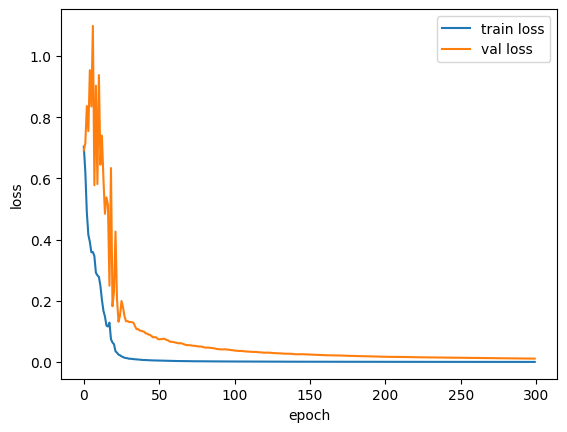

Accuracy: 98.14814814814815%


In [4]:
TOP_5_CONFIGS_INDEXES = sorted(CONFIG_DICTIONARY, key=CONFIG_DICTIONARY.get, reverse=True)[:5]

print("Top 5 configurations:")
for i in TOP_5_CONFIGS_INDEXES:
    ACCURACY = CONFIG_DICTIONARY[i] * 100 / len(K_FOLDS)
    print(f"Config index: {CONFIGURATIONS[i]}, Mean Accuracy: {ACCURACY}%")

NEURAL_NETWORK_ARCHITECTURE, NEURAL_NETWORK_ACTIVATION, LOSS_F, ETA, LAMBDA, ALPHA = CONFIGURATIONS[TOP_5_CONFIGS_INDEXES[0]]
print(monk_dataset_1.X_train.shape, monk_dataset_1.y_train.shape, X_test.shape, y_test.shape)
X_train, y_train, X_val, y_val = monk_dataset_1.train_val_split(portion=0.8)
print(X_train.shape, y_train.shape, X_val.shape, y_val.shape)
nn = NeuralNetwork(NEURAL_NETWORK_ARCHITECTURE, NEURAL_NETWORK_ACTIVATION, std=0.2)
trainer = Trainer(
    nn=nn,
    loss=Loss(LOSS_F),
    X_train=X_train,
    y_train=y_train, #no scaling y because of onehot
    X_val = X_val,
    y_val=y_val,
    epochs=EPOCHS,
    early_stopping=100, # no improvements in 50 epochs_> stop
    eta=ETA,               # Learning rate iniziale
    lam=LAMBDA,                # L2
    alpha=ALPHA,               # Momentum
    batch_size=16,
    shuffle_batches=True
)
# return_best_nn=True returns the best nn
best_nn = trainer.train(return_best_nn=True, print_epochs=False, plot_epochs=True)
#best val accuracy
out = best_nn.forward(X_test)[-1][-1]
if LOSS_F == 'binary cross entropy sigmoid':
  out = sigmoid(out)

predictions = np.round(out)
print(f"Accuracy: {np.mean(predictions == y_test) * 100}%")
CONFIG_DICTIONARY[i] += np.mean(predictions == y_test)

## Monk 2

In [5]:
PATH_TRAIN = 'data/monk/monks-2.train'
PATH_TEST = 'data/monk/monks-2.test'

df_train = pd.read_csv(PATH_TRAIN, sep='\s+', header=None) #sep='\s+' == delim white space
df_test = pd.read_csv(PATH_TEST, sep='\s+', header=None)

#Convert df in numpy arrays, excluding last column
Train_set = np.array(df_train.iloc[:, :-1], dtype=np.int32)
Test_set = np.array(df_test.iloc[:, :-1], dtype=np.int32)
print(f" Train set shape: {Train_set.shape}, Test set shape: {Test_set.shape}")
X_train_full = onehot_monk(Train_set[:, 1:]) 
y_train_full = np.reshape(Train_set[:, 0], (len(Train_set), 1))# only first column, need shape (n,1) to work

X_test = onehot_monk(Test_set[:, 1:]) 
y_test = np.reshape(Test_set[:, 0], (len(Test_set), 1))
print(f'After one-hot encoding: X train full shape: {X_train_full.shape}, X test shape: {X_test.shape}, y train full shape: {y_train_full.shape}, y test shape: {y_test.shape}')

 Train set shape: (169, 7), Test set shape: (432, 7)
After one-hot encoding: X train full shape: (169, 17), X test shape: (432, 17), y train full shape: (169, 1), y test shape: (432, 1)


In [6]:
INPUT_NEURONS = 17
OUTPUT_NEURONS = 1

HIDDEN_LAYER_SIZES = [8, 16]
HIDDEN_LAYERS_COUNTS = [1, 2]
INTERNAL_ACTIVATIONS = ['tanh', 'leaky relu', 'relu']
OUTPUT_ACTIVATIONS_AND_LOSS = [('sigmoid', 'mse'), ('identity', 'binary cross entropy sigmoid')]
NEURAL_NETWORK_CONFIGURATIONS = []

for hidden_layers_count in HIDDEN_LAYERS_COUNTS:
    for hidden_layer_size in HIDDEN_LAYER_SIZES:
        for internal_activation in INTERNAL_ACTIVATIONS:
            for output_activation, loss_function in OUTPUT_ACTIVATIONS_AND_LOSS:
                architecture = [INPUT_NEURONS] + [hidden_layer_size] * hidden_layers_count + [OUTPUT_NEURONS]
                activations = [internal_activation] * hidden_layers_count + [output_activation]
                NEURAL_NETWORK_CONFIGURATIONS.append((architecture, activations, loss_function))

monk_dataset_2 = DataLoader(X_train_full, y_train_full)
K_FOLDS = monk_dataset_2.k_fold(k = 5)

ETA_CONFIGURATIONS = [0.01, 0.001]
LAMBDA_CONFIGURATIONS = [0, 1e-3, 1e-4]
ALPHA_CONFIGURATIONS = [0, 0.5, 0.9]
EPOCHS = 300

# (NEURAL_NETWORK_ARCHITECTURE, NEURAL_NETWORK_ACTIVATION, LOSS_F, ETA, LAMBDA, ALPHA)
CONFIGURATIONS = []

for NEURAL_NETWORK_ARCHITECTURE, NEURAL_NETWORK_ACTIVATION, LOSS_F in NEURAL_NETWORK_CONFIGURATIONS:
  for ETA in ETA_CONFIGURATIONS:
    for LAMBDA in LAMBDA_CONFIGURATIONS:
      for ALPHA in ALPHA_CONFIGURATIONS:
        config = (NEURAL_NETWORK_ARCHITECTURE, NEURAL_NETWORK_ACTIVATION, LOSS_F, ETA, LAMBDA, ALPHA)
        CONFIGURATIONS.append(config)

CONFIG_DICTIONARY = {}
LEN_CONFIGURATIONS = len(CONFIGURATIONS)
for i in range(LEN_CONFIGURATIONS):
  CONFIG_DICTIONARY[i] = 0


for i in range(LEN_CONFIGURATIONS):
  print(f"Training {i+1}/{LEN_CONFIGURATIONS}")
  config = CONFIGURATIONS[i]
  for X_train, y_train, X_val, y_val in K_FOLDS:
    NEURAL_NETWORK_ARCHITECTURE, NEURAL_NETWORK_ACTIVATION, LOSS_F, ETA, LAMBDA, ALPHA = config
    print(f"NEURAL_NETWORK_ARCHITECTURE: {NEURAL_NETWORK_ARCHITECTURE}, NEURAL_NETWORK_ACTIVATION: {NEURAL_NETWORK_ACTIVATION}, LOSS_F: {LOSS_F}, ETA: {ETA}, LAMBDA: {LAMBDA}, ALPHA: {ALPHA}")
    #train
    nn = NeuralNetwork(NEURAL_NETWORK_ARCHITECTURE, NEURAL_NETWORK_ACTIVATION, std=0.2)
    trainer = Trainer(
        nn=nn,
        loss=Loss(LOSS_F),
        X_train=X_train,
        y_train=y_train, #no scaling y because of onehot
        X_val=X_val,
        y_val=y_val,
        epochs=EPOCHS,
        early_stopping=100, # no improvements in 50 epochs_> stop
        eta=ETA,               # Learning rate iniziale
        lam=LAMBDA,                # L2
        alpha=ALPHA,               # Momentum
        batch_size=16,
        shuffle_batches=True
    )
    # return_best_nn=True returns the best nn
    best_nn = trainer.train(return_best_nn=True, print_epochs=False, plot_epochs=False)
    #best val accuracy
    out = best_nn.forward(X_val)[-1][-1]
    if LOSS_F == 'binary cross entropy sigmoid':
      out = sigmoid(out)
    
    predictions = np.round(out)
    print(f"Accuracy: {np.mean(predictions == y_val) * 100}%")
    CONFIG_DICTIONARY[i] += np.mean(predictions == y_val)

Training 1/432
NEURAL_NETWORK_ARCHITECTURE: [17, 8, 1], NEURAL_NETWORK_ACTIVATION: ['tanh', 'sigmoid'], LOSS_F: mse, ETA: 0.01, LAMBDA: 0, ALPHA: 0
Accuracy: 73.52941176470588%
NEURAL_NETWORK_ARCHITECTURE: [17, 8, 1], NEURAL_NETWORK_ACTIVATION: ['tanh', 'sigmoid'], LOSS_F: mse, ETA: 0.01, LAMBDA: 0, ALPHA: 0
Accuracy: 100.0%
NEURAL_NETWORK_ARCHITECTURE: [17, 8, 1], NEURAL_NETWORK_ACTIVATION: ['tanh', 'sigmoid'], LOSS_F: mse, ETA: 0.01, LAMBDA: 0, ALPHA: 0
Accuracy: 100.0%
NEURAL_NETWORK_ARCHITECTURE: [17, 8, 1], NEURAL_NETWORK_ACTIVATION: ['tanh', 'sigmoid'], LOSS_F: mse, ETA: 0.01, LAMBDA: 0, ALPHA: 0
Accuracy: 55.88235294117647%
NEURAL_NETWORK_ARCHITECTURE: [17, 8, 1], NEURAL_NETWORK_ACTIVATION: ['tanh', 'sigmoid'], LOSS_F: mse, ETA: 0.01, LAMBDA: 0, ALPHA: 0
Accuracy: 64.70588235294117%
Training 2/432
NEURAL_NETWORK_ARCHITECTURE: [17, 8, 1], NEURAL_NETWORK_ACTIVATION: ['tanh', 'sigmoid'], LOSS_F: mse, ETA: 0.01, LAMBDA: 0, ALPHA: 0.5
Accuracy: 100.0%
NEURAL_NETWORK_ARCHITECTURE: [17

Top 5 configurations:
Config index: ([17, 8, 1], ['tanh', 'sigmoid'], 'mse', 0.01, 0.0001, 0.9), Mean Accuracy: 100.0%
Config index: ([17, 8, 1], ['tanh', 'identity'], 'binary cross entropy sigmoid', 0.01, 0, 0.5), Mean Accuracy: 100.0%
Config index: ([17, 8, 1], ['tanh', 'identity'], 'binary cross entropy sigmoid', 0.01, 0, 0.9), Mean Accuracy: 100.0%
Config index: ([17, 8, 1], ['tanh', 'identity'], 'binary cross entropy sigmoid', 0.01, 0.001, 0.5), Mean Accuracy: 100.0%
Config index: ([17, 8, 1], ['tanh', 'identity'], 'binary cross entropy sigmoid', 0.01, 0.001, 0.9), Mean Accuracy: 100.0%
(169, 17) (169, 1) (432, 17) (432, 1)
(135, 17) (135, 1) (34, 17) (34, 1)


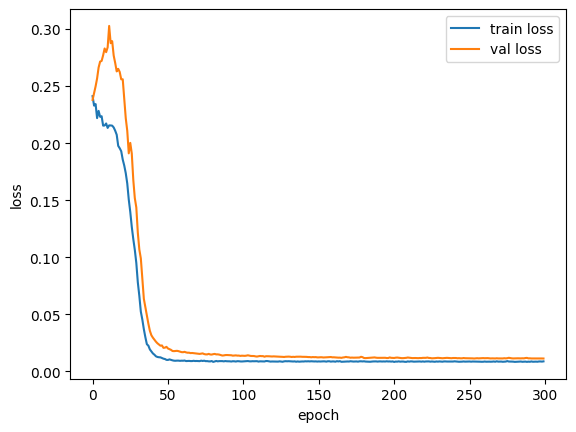

Accuracy: 100.0%


In [7]:
TOP_5_CONFIGS_INDEXES = sorted(CONFIG_DICTIONARY, key=CONFIG_DICTIONARY.get, reverse=True)[:5]

print("Top 5 configurations:")
for i in TOP_5_CONFIGS_INDEXES:
    ACCURACY = CONFIG_DICTIONARY[i] * 100 / len(K_FOLDS)
    print(f"Config index: {CONFIGURATIONS[i]}, Mean Accuracy: {ACCURACY}%")

NEURAL_NETWORK_ARCHITECTURE, NEURAL_NETWORK_ACTIVATION, LOSS_F, ETA, LAMBDA, ALPHA = CONFIGURATIONS[TOP_5_CONFIGS_INDEXES[0]]
print(monk_dataset_2.X_train.shape, monk_dataset_2.y_train.shape, X_test.shape, y_test.shape)
X_train, y_train, X_val, y_val = monk_dataset_2.train_val_split(portion=0.8)
print(X_train.shape, y_train.shape, X_val.shape, y_val.shape)
nn = NeuralNetwork(NEURAL_NETWORK_ARCHITECTURE, NEURAL_NETWORK_ACTIVATION, std=0.2)
trainer = Trainer(
    nn=nn,
    loss=Loss(LOSS_F),
    X_train=X_train,
    y_train=y_train, #no scaling y because of onehot
    X_val = X_val,
    y_val=y_val,
    epochs=EPOCHS,
    early_stopping=100, # no improvements in 50 epochs_> stop
    eta=ETA,               # Learning rate iniziale
    lam=LAMBDA,                # L2
    alpha=ALPHA,               # Momentum
    batch_size=16,
    shuffle_batches=True
)
# return_best_nn=True returns the best nn
best_nn = trainer.train(return_best_nn=True, print_epochs=False, plot_epochs=True)
#best val accuracy
out = best_nn.forward(X_test)[-1][-1]
if LOSS_F == 'binary cross entropy sigmoid':
  out = sigmoid(out)

predictions = np.round(out)
print(f"Accuracy: {np.mean(predictions == y_test) * 100}%")
CONFIG_DICTIONARY[i] += np.mean(predictions == y_test)

## Monk 3

In [8]:
PATH_TRAIN = 'data/monk/monks-3.train'
PATH_TEST = 'data/monk/monks-3.test'

df_train = pd.read_csv(PATH_TRAIN, sep='\s+', header=None) #sep='\s+' == delim white space
df_test = pd.read_csv(PATH_TEST, sep='\s+', header=None)

#Convert df in numpy arrays, excluding last column
Train_set = np.array(df_train.iloc[:, :-1], dtype=np.int32)
Test_set = np.array(df_test.iloc[:, :-1], dtype=np.int32)
print(f" Train set shape: {Train_set.shape}, Test set shape: {Test_set.shape}")
X_train_full = onehot_monk(Train_set[:, 1:]) 
y_train_full = np.reshape(Train_set[:, 0], (len(Train_set), 1))# only first column, need shape (n,1) to work

X_test = onehot_monk(Test_set[:, 1:]) 
y_test = np.reshape(Test_set[:, 0], (len(Test_set), 1))
print(f'After one-hot encoding: X train full shape: {X_train_full.shape}, X test shape: {X_test.shape}, y train full shape: {y_train_full.shape}, y test shape: {y_test.shape}')

 Train set shape: (122, 7), Test set shape: (432, 7)
After one-hot encoding: X train full shape: (122, 17), X test shape: (432, 17), y train full shape: (122, 1), y test shape: (432, 1)


In [9]:
INPUT_NEURONS = 17
OUTPUT_NEURONS = 1

HIDDEN_LAYER_SIZES = [8, 16]
HIDDEN_LAYERS_COUNTS = [1, 2]
INTERNAL_ACTIVATIONS = ['tanh', 'leaky relu', 'relu']
OUTPUT_ACTIVATIONS_AND_LOSS = [('sigmoid', 'mse'), ('identity', 'binary cross entropy sigmoid')]
NEURAL_NETWORK_CONFIGURATIONS = []

for hidden_layers_count in HIDDEN_LAYERS_COUNTS:
    for hidden_layer_size in HIDDEN_LAYER_SIZES:
        for internal_activation in INTERNAL_ACTIVATIONS:
            for output_activation, loss_function in OUTPUT_ACTIVATIONS_AND_LOSS:
                architecture = [INPUT_NEURONS] + [hidden_layer_size] * hidden_layers_count + [OUTPUT_NEURONS]
                activations = [internal_activation] * hidden_layers_count + [output_activation]
                NEURAL_NETWORK_CONFIGURATIONS.append((architecture, activations, loss_function))

monk_dataset_3 = DataLoader(X_train_full, y_train_full)
K_FOLDS = monk_dataset_3.k_fold(k = 5)

ETA_CONFIGURATIONS = [0.01, 0.001]
LAMBDA_CONFIGURATIONS = [0, 1e-3, 1e-4]
ALPHA_CONFIGURATIONS = [0, 0.5, 0.9]
EPOCHS = 300

# (NEURAL_NETWORK_ARCHITECTURE, NEURAL_NETWORK_ACTIVATION, LOSS_F, ETA, LAMBDA, ALPHA)
CONFIGURATIONS = []

for NEURAL_NETWORK_ARCHITECTURE, NEURAL_NETWORK_ACTIVATION, LOSS_F in NEURAL_NETWORK_CONFIGURATIONS:
  for ETA in ETA_CONFIGURATIONS:
    for LAMBDA in LAMBDA_CONFIGURATIONS:
      for ALPHA in ALPHA_CONFIGURATIONS:
        config = (NEURAL_NETWORK_ARCHITECTURE, NEURAL_NETWORK_ACTIVATION, LOSS_F, ETA, LAMBDA, ALPHA)
        CONFIGURATIONS.append(config)

CONFIG_DICTIONARY = {}
LEN_CONFIGURATIONS = len(CONFIGURATIONS)
for i in range(LEN_CONFIGURATIONS):
  CONFIG_DICTIONARY[i] = 0


for i in range(LEN_CONFIGURATIONS):
  print(f"Training {i+1}/{LEN_CONFIGURATIONS}")
  config = CONFIGURATIONS[i]
  for X_train, y_train, X_val, y_val in K_FOLDS:
    NEURAL_NETWORK_ARCHITECTURE, NEURAL_NETWORK_ACTIVATION, LOSS_F, ETA, LAMBDA, ALPHA = config
    print(f"NEURAL_NETWORK_ARCHITECTURE: {NEURAL_NETWORK_ARCHITECTURE}, NEURAL_NETWORK_ACTIVATION: {NEURAL_NETWORK_ACTIVATION}, LOSS_F: {LOSS_F}, ETA: {ETA}, LAMBDA: {LAMBDA}, ALPHA: {ALPHA}")
    #train
    nn = NeuralNetwork(NEURAL_NETWORK_ARCHITECTURE, NEURAL_NETWORK_ACTIVATION, std=0.2)
    trainer = Trainer(
        nn=nn,
        loss=Loss(LOSS_F),
        X_train=X_train,
        y_train=y_train, #no scaling y because of onehot
        X_val=X_val,
        y_val=y_val,
        epochs=EPOCHS,
        early_stopping=100, # no improvements in 50 epochs_> stop
        eta=ETA,               # Learning rate iniziale
        lam=LAMBDA,                # L2
        alpha=ALPHA,               # Momentum
        batch_size=16,
        shuffle_batches=True
    )
    # return_best_nn=True returns the best nn
    best_nn = trainer.train(return_best_nn=True, print_epochs=False, plot_epochs=False)
    #best val accuracy
    out = best_nn.forward(X_val)[-1][-1]
    if LOSS_F == 'binary cross entropy sigmoid':
      out = sigmoid(out)
    
    predictions = np.round(out)
    print(f"Accuracy: {np.mean(predictions == y_val) * 100}%")
    CONFIG_DICTIONARY[i] += np.mean(predictions == y_val)

Training 1/432
NEURAL_NETWORK_ARCHITECTURE: [17, 8, 1], NEURAL_NETWORK_ACTIVATION: ['tanh', 'sigmoid'], LOSS_F: mse, ETA: 0.01, LAMBDA: 0, ALPHA: 0
Accuracy: 91.66666666666666%
NEURAL_NETWORK_ARCHITECTURE: [17, 8, 1], NEURAL_NETWORK_ACTIVATION: ['tanh', 'sigmoid'], LOSS_F: mse, ETA: 0.01, LAMBDA: 0, ALPHA: 0
Accuracy: 100.0%
NEURAL_NETWORK_ARCHITECTURE: [17, 8, 1], NEURAL_NETWORK_ACTIVATION: ['tanh', 'sigmoid'], LOSS_F: mse, ETA: 0.01, LAMBDA: 0, ALPHA: 0
Accuracy: 100.0%
NEURAL_NETWORK_ARCHITECTURE: [17, 8, 1], NEURAL_NETWORK_ACTIVATION: ['tanh', 'sigmoid'], LOSS_F: mse, ETA: 0.01, LAMBDA: 0, ALPHA: 0
Accuracy: 84.0%
NEURAL_NETWORK_ARCHITECTURE: [17, 8, 1], NEURAL_NETWORK_ACTIVATION: ['tanh', 'sigmoid'], LOSS_F: mse, ETA: 0.01, LAMBDA: 0, ALPHA: 0
Accuracy: 95.83333333333334%
Training 2/432
NEURAL_NETWORK_ARCHITECTURE: [17, 8, 1], NEURAL_NETWORK_ACTIVATION: ['tanh', 'sigmoid'], LOSS_F: mse, ETA: 0.01, LAMBDA: 0, ALPHA: 0.5
Accuracy: 91.66666666666666%
NEURAL_NETWORK_ARCHITECTURE: [17,

Top 5 configurations:
Config index: ([17, 8, 8, 1], ['leaky relu', 'leaky relu', 'sigmoid'], 'mse', 0.01, 0, 0.9), Mean Accuracy: 95.93333333333334%
Config index: ([17, 16, 1], ['tanh', 'sigmoid'], 'mse', 0.01, 0, 0.9), Mean Accuracy: 95.1%
Config index: ([17, 8, 8, 1], ['relu', 'relu', 'sigmoid'], 'mse', 0.01, 0, 0.9), Mean Accuracy: 95.1%
Config index: ([17, 8, 8, 1], ['relu', 'relu', 'sigmoid'], 'mse', 0.01, 0.0001, 0.5), Mean Accuracy: 95.1%
Config index: ([17, 16, 16, 1], ['leaky relu', 'leaky relu', 'sigmoid'], 'mse', 0.01, 0, 0.9), Mean Accuracy: 95.1%
(122, 17) (122, 1) (432, 17) (432, 1)
(97, 17) (97, 1) (25, 17) (25, 1)


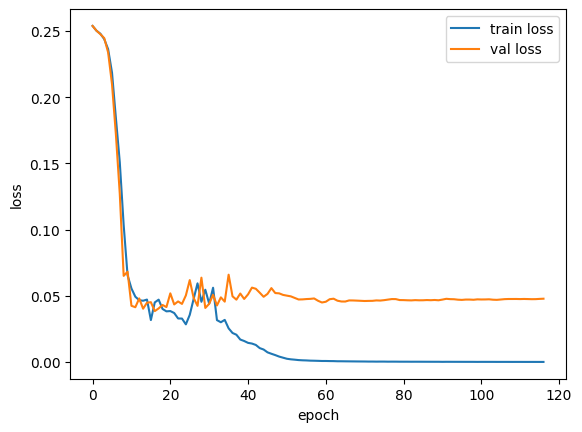

Accuracy: 96.06481481481481%


In [10]:
TOP_5_CONFIGS_INDEXES = sorted(CONFIG_DICTIONARY, key=CONFIG_DICTIONARY.get, reverse=True)[:5]

print("Top 5 configurations:")
for i in TOP_5_CONFIGS_INDEXES:
    ACCURACY = CONFIG_DICTIONARY[i] * 100 / len(K_FOLDS)
    print(f"Config index: {CONFIGURATIONS[i]}, Mean Accuracy: {ACCURACY}%")

NEURAL_NETWORK_ARCHITECTURE, NEURAL_NETWORK_ACTIVATION, LOSS_F, ETA, LAMBDA, ALPHA = CONFIGURATIONS[TOP_5_CONFIGS_INDEXES[0]]
print(monk_dataset_3.X_train.shape, monk_dataset_3.y_train.shape, X_test.shape, y_test.shape)
X_train, y_train, X_val, y_val = monk_dataset_3.train_val_split(portion=0.8)
print(X_train.shape, y_train.shape, X_val.shape, y_val.shape)
nn = NeuralNetwork(NEURAL_NETWORK_ARCHITECTURE, NEURAL_NETWORK_ACTIVATION, std=0.2)
trainer = Trainer(
    nn=nn,
    loss=Loss(LOSS_F),
    X_train=X_train,
    y_train=y_train, #no scaling y because of onehot
    X_val = X_val,
    y_val=y_val,
    epochs=EPOCHS,
    early_stopping=100, # no improvements in 50 epochs_> stop
    eta=ETA,               # Learning rate iniziale
    lam=LAMBDA,                # L2
    alpha=ALPHA,               # Momentum
    batch_size=16,
    shuffle_batches=True
)
# return_best_nn=True returns the best nn
best_nn = trainer.train(return_best_nn=True, print_epochs=False, plot_epochs=True)
#best val accuracy
out = best_nn.forward(X_test)[-1][-1]
if LOSS_F == 'binary cross entropy sigmoid':
  out = sigmoid(out)

predictions = np.round(out)
print(f"Accuracy: {np.mean(predictions == y_test) * 100}%")
CONFIG_DICTIONARY[i] += np.mean(predictions == y_test)